# LLM Basics

## Introduction

Large Language Models are generative ML models, that can produce coherent and contextually relevant text based on input data, predicting the continuation of the input.

LLMs leverage the Transformer model, which prioritizes context in sentences through self-attention.  
They are pre-trained on extensive text data and can be fine-tuned for specific tasks like summarization or question answering.

Below we will see how one can use a tools like Langchain to solve various tasks with LLMs.

## Chat completion 

Communication with LLM in chat format.  

Dialog usually consists of 2-3 types of messages:
- **Human** message: what we want to tell the model. This can be either just a user input or a user input with some additional text. We will see examples further in this section.
- **Assistant/AI** message: response given by LLM. Although it is provided to us by LLM we still can use it in LLM input, e.g. to provide history.
- **System** message: optional type of messages. It is written by a developer rather than user and can provide general idea of the task or give some important information that the model always has to keep in mind. Most models support this type of message.

Modern models are aligned to respect different types of messages in their input, however different models may require different formatting of their input. 

Basic and the most common parameters of an LLM
- model name
- prompt that will have the task for the model and should be a string
- `temperature` -- aka randomness or 'creativity' of an output, `[0, 1]`. 0 -- no random, the output will be the same all the executions. 1 -- the output will be very different each execution.
- `max_tokens` -- limits the number of tokens in the output.
- `top_p` -- An alternative to sampling with temperature, called nucleus sampling, where the model considers the results of the tokens with top_p probability mass. So 0.1 means only the tokens comprising the top 10% probability mass are considered (you should alter this or temperature but not both).

Different models were trained on different data.  
For some of the models it means noticeable differences between prompt structures that they accept.  
Most of the models accept a system prompt like on the example below.

In [168]:
import json
from pprint import pprint

# Load the default model
DEFAULT_MODEL = json.load(open('./configs/mistral.json', 'r'))

### Langchain

Let's see how we can utilize Langchain for basic interaction with an llm.

API documentation: https://python.langchain.com/api_reference/openai/chat_models/langchain_openai.chat_models.base.ChatOpenAI.html

Notebook tutorial: https://python.langchain.com/docs/integrations/chat/openai/

Langchain supports connectors to various providers like Azure Open AI services or AWS Bedrock. [You can find them here.](https://python.langchain.com/docs/integrations/providers/)  

On the other hand, most of the providers and inference tools (e.g. vLLM) implement OpenAI compatible API, which means we can utilize an OpenAI client wrapper from Langchain to interact with them.

In [169]:
from langchain_openai import ChatOpenAI

In [170]:
llm = ChatOpenAI(temperature=0.0,
                  model= DEFAULT_MODEL["model"],
                  api_key=DEFAULT_MODEL["api_key"],
                  base_url=DEFAULT_MODEL["api_base"])
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001A806A3C1D0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001A807909580>, root_client=<openai.OpenAI object at 0x000001A801CD2DE0>, root_async_client=<openai.AsyncOpenAI object at 0x000001A806A3D280>, model_name='Mistral', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://mistral-api.llm.lab.epam.com/v1')

Let's create a simple prompt to change text style.

In [171]:
template_string = """Translate the text \
that is delimited by triple backticks \
into a style that is {style}. \
text: ```{text}```
"""

messages = [
    (
        "system",
        "You are a helpful assistant that helps editing the text.",
    ),
    ("human", template_string),
]

As you can see, we can utilize list of messages to create a prompt.  

This is might be especially useful if you work on a chat application and utilize history of interactions between user and your service.

In [172]:
from langchain_core.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_messages(messages)
prompt_template.messages[0].prompt, prompt_template.messages[1].prompt 

(PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant that helps editing the text.'),
 PromptTemplate(input_variables=['style', 'text'], input_types={}, partial_variables={}, template='Translate the text that is delimited by triple backticks into a style that is {style}. text: ```{text}```\n'))

We will ask to rewrite the user message in an appropriate style.

In [173]:
customer_style = """American English \
in a calm and respectful tone
"""

customer_email = """
Arrr, I be fuming that me blender lid \
flew off and splattered me kitchen walls \
with smoothie! And to make matters worse, \
the warranty don't cover the cost of \
cleaning up me kitchen. I need yer help \
right now, matey!
"""

Here is the filled prompt

In [174]:
customer_messages = prompt_template.format_messages(
                    style=customer_style,
                    text=customer_email)

pprint([c.content for c in customer_messages])

['You are a helpful assistant that helps editing the text.',
 'Translate the text that is delimited by triple backticks into a style that '
 'is American English in a calm and respectful tone\n'
 '. text: ```\n'
 'Arrr, I be fuming that me blender lid flew off and splattered me kitchen '
 "walls with smoothie! And to make matters worse, the warranty don't cover the "
 'cost of cleaning up me kitchen. I need yer help right now, matey!\n'
 '```\n']


In [175]:
# Call the LLM to translate to the style of the customer message
customer_response = llm.invoke(customer_messages)
pprint(customer_response.content)

('Sure, here is the text translated into American English with a calm and '
 'respectful tone:\n'
 '\n'
 '```\n'
 "I'm quite upset because the lid of my blender flew off and splattered "
 'smoothie all over my kitchen walls. To make matters worse, the warranty '
 "doesn't cover the cost of cleaning up the mess. I could really use your help "
 'right now.\n'
 '```')


In [176]:
print(customer_response.content)

Sure, here is the text translated into American English with a calm and respectful tone:

```
I'm quite upset because the lid of my blender flew off and splattered smoothie all over my kitchen walls. To make matters worse, the warranty doesn't cover the cost of cleaning up the mess. I could really use your help right now.
```


In [177]:
type(customer_response)

langchain_core.messages.ai.AIMessage

We got an AIMessage with the result as a response.

### OpenAI Client

An alternative to Langchain when calling an LLM is an `openai` client.  
It's principal is mostly similar to Langchain, but the code specifics are different.

If you interact with the OpenAI endpoints directly, the latest version of this client would support the latest changes and features of their models and API.

Documentation: https://platform.openai.com/docs/api-reference/chat/create

The **role** here is specifying who exactly sends the message, whether its from Human or from AI.  
- **system role** is not required, but helpful to specify how a model should consider itself.  
- **human role** are possible inputs from the user helping a model to 'fit' on them 
- **assistant** -- examples of a desired behavior on the user's inputs 

Let's create a client

In [178]:
import openai

# Set the base URL and API key
# For production apps it's preferable to use some secret management system and don't store the key in git repo :)

client = openai.OpenAI(
    base_url = DEFAULT_MODEL['api_base'], 
    api_key = DEFAULT_MODEL['api_key']
    )

Here is an example of an interaction:

In [179]:
response = client.chat.completions.create(
  model=DEFAULT_MODEL["model"],
  messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Who won the world series in 2020?"},
        {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
        {"role": "user", "content": "Where was it played?"},
    ]
)

In [180]:
# Example of an output completion object:
print(response)

ChatCompletion(id='chatcmpl-c8f6b71aefffb5efeb400a9b3064c381', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The 2020 World Series was played at Globe Life Field in Arlington, Texas. Due to the COVID-19 pandemic, both the American League Champion Tampa Bay Rays and the National League Champion Los Angeles Dodgers played their games in neutral-site venues in Texas, with the Rays using Tropicana Field in Florida for games that did not indicate which venue they would end up playing as most games were played at Globe Life Field.\n\nThanks for your kind words! If you have any more questions, feel free to ask.', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None), stop_reason=None)], created=1743876670, model='Mistral', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=107, prompt_tokens=44, total_tokens=151, c

Here is a content of the response.  
Note that we've got a single response (choice) as `n == 1` by default – number of different completions to generate

In [181]:
pprint(response.choices[0].message.content.strip())

('The 2020 World Series was played at Globe Life Field in Arlington, Texas. '
 'Due to the COVID-19 pandemic, both the American League Champion Tampa Bay '
 'Rays and the National League Champion Los Angeles Dodgers played their games '
 'in neutral-site venues in Texas, with the Rays using Tropicana Field in '
 'Florida for games that did not indicate which venue they would end up '
 'playing as most games were played at Globe Life Field.\n'
 '\n'
 'Thanks for your kind words! If you have any more questions, feel free to '
 'ask.')


## Tokenization

Tokenization is a transformation of raw text into sequence of numbers consumable by a model. 

This process might be tricky and simple splitting by whitespace or punctuation is not enough: you might need to account for different languages, and notations.

The most popular and widespread algorithm right now is [Byte Pair Encoding (BPE)](https://en.wikipedia.org/wiki/Byte_pair_encoding).   
In contrast to rule-based tokenizers, it heavily utilizes the statistics over large amount of texts, which results in rather compact vocabulary of sub-words that cover majority of texts.

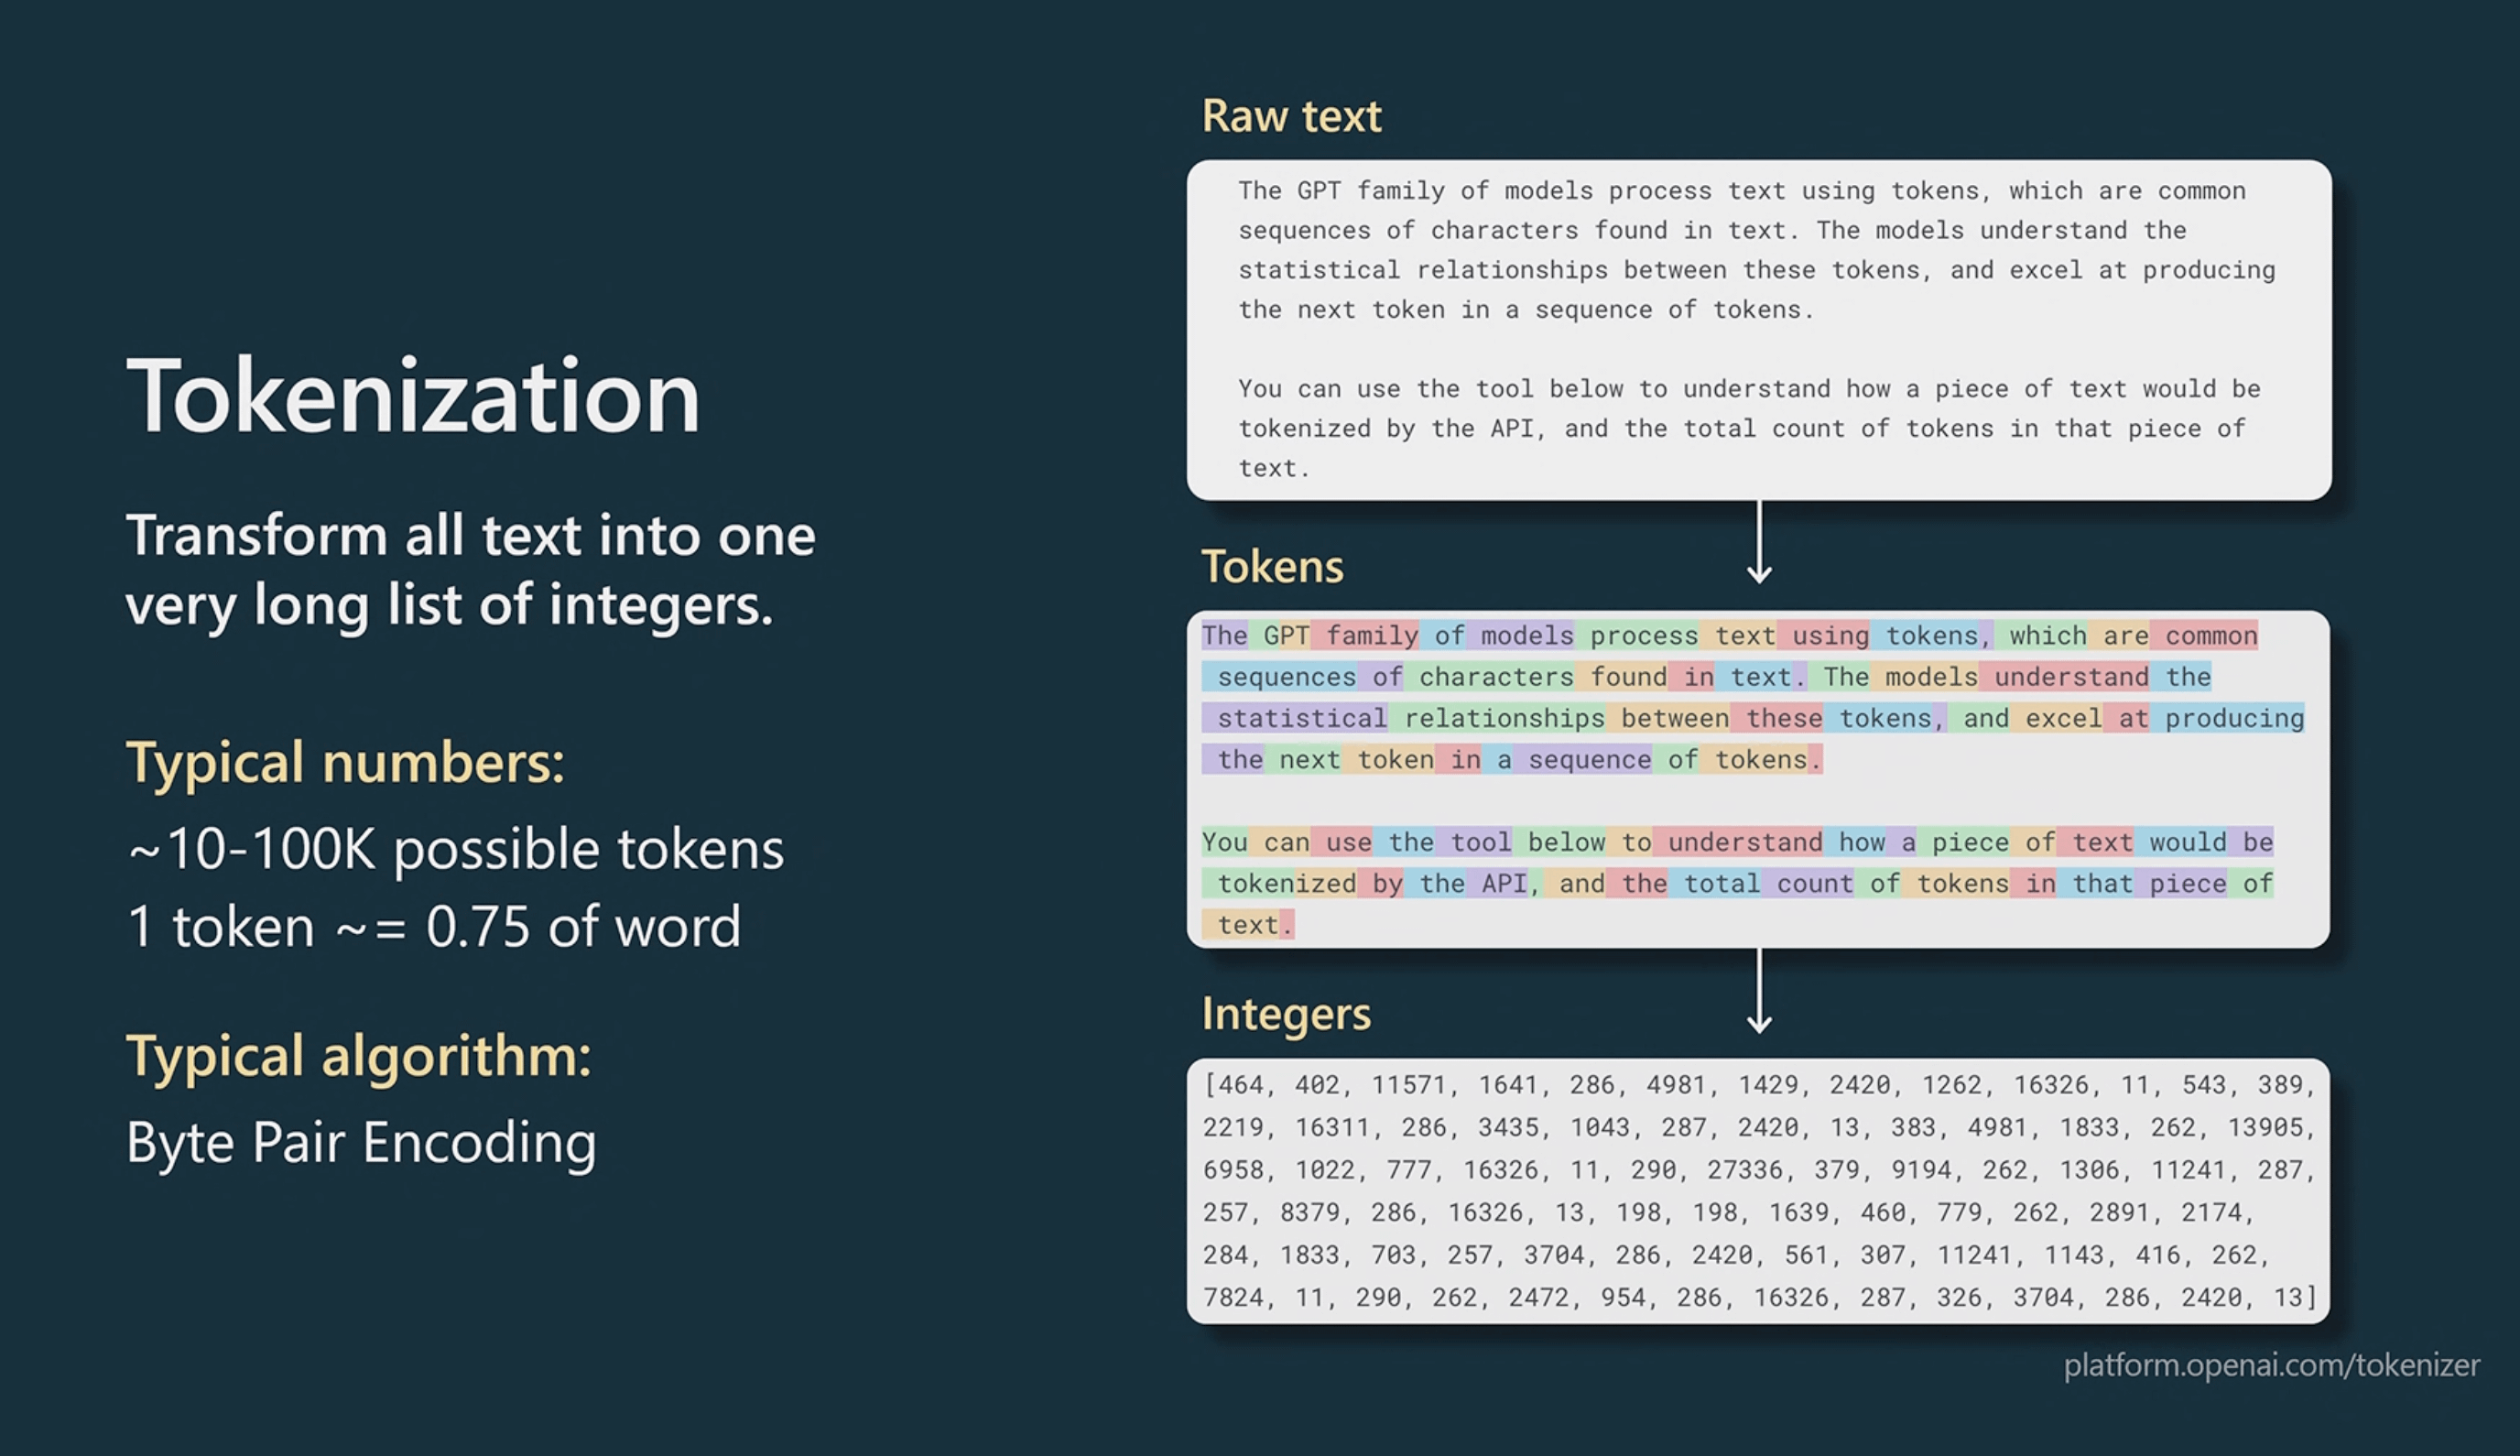

In order to understand whether your prompt is going to fit the context or what price that you're going to pay for your input prompt, you can calculate the number of tokens in advance. 

This is important as different models have different context windows (limit of input size) as well as different token vocabulary – the same text maybe tokenized differently by different models.

For OpenAI models you can use OpenAI's own bpe tokenizer with [`tiktoken`](https://github.com/openai/tiktoken) library.

In [182]:
import tiktoken

encoding = tiktoken.encoding_for_model('gpt-4o-mini')

This is the encoded version of input text.

In [183]:
example_tokens = encoding.encode("Hello world")
example_tokens

[13225, 2375]

Number of tokens:

In [184]:
len(example_tokens)

2

You can use the same library to decode tokens back to original form.

In [185]:
encoding.decode(example_tokens)

'Hello world'

When you are using non-OpenAI model you can load the tokenizer elsewhere if available and calculate tokens with it.  
For example huggingface's transformers: https://huggingface.co/docs/transformers/main_classes/tokenizer

## Simple prompt engineering techniques 

In [186]:
from langchain_core.prompts import PromptTemplate

example_prompt = PromptTemplate.from_template("Question: {question}\n{answer}")

### Few-shot prompts


We can give examples of questions and answers directly in the prompt. With good enough model it can help to keep the proper response structure and to satisfy requirements.

See more here: https://www.promptingguide.ai/techniques/fewshot


In [187]:
examples = [
    {
        "question": "Who lived longer, Muhammad Ali or Alan Turing?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali
""",
    },
    {
        "question": "When was the founder of craigslist born?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952
""",
    },
    {
        "question": "Who was the maternal grandfather of George Washington?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.
So the final answer is: Joseph Ball
""",
    },
    {
        "question": "Are both the directors of Jaws and Casino Royale from the same country?",
        "answer": """
Are follow up questions needed here: Yes.
Follow up: Who is the director of Jaws?
Intermediate Answer: The director of Jaws is Steven Spielberg.
Follow up: Where is Steven Spielberg from?
Intermediate Answer: The United States.
Follow up: Who is the director of Casino Royale?
Intermediate Answer: The director of Casino Royale is Martin Campbell.
Follow up: Where is Martin Campbell from?
Intermediate Answer: New Zealand.
So the final answer is: No
""",
    },
]

Without any examples:

In [188]:
pprint(llm.invoke(examples[0]["question"]).content)

('Alan Turing lived longer than Muhammad Ali.\n'
 '\n'
 '- Alan Turing was born on June 23, 1912, and died on June 7, 1954, at the '
 'age of 41.\n'
 '- Muhammad Ali was born on January 17, 1942, and died on June 3, 2016, at '
 'the age of 74.\n'
 '\n'
 'Therefore, Muhammad Ali lived longer.')


Now, let's try with examples.  
First, let's see the formatted prompt with our query in the very end.

In [189]:
from langchain_core.prompts import FewShotPromptTemplate

prompt = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    suffix="Question: {input}",
    input_variables=["input"],
)

print(
    prompt.invoke({"input": "Who was the father of Mary Ball Washington?"}).to_string()
)

Question: Who lived longer, Muhammad Ali or Alan Turing?

Are follow up questions needed here: Yes.
Follow up: How old was Muhammad Ali when he died?
Intermediate answer: Muhammad Ali was 74 years old when he died.
Follow up: How old was Alan Turing when he died?
Intermediate answer: Alan Turing was 41 years old when he died.
So the final answer is: Muhammad Ali


Question: When was the founder of craigslist born?

Are follow up questions needed here: Yes.
Follow up: Who was the founder of craigslist?
Intermediate answer: Craigslist was founded by Craig Newmark.
Follow up: When was Craig Newmark born?
Intermediate answer: Craig Newmark was born on December 6, 1952.
So the final answer is: December 6, 1952


Question: Who was the maternal grandfather of George Washington?

Are follow up questions needed here: Yes.
Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.
Follow up: Who was the father of Mary Ball W

Now, let's try to generate an answer

In [190]:
print(llm.invoke(prompt.invoke({"input": "Who was the father of Mary Ball Washington?"})).content)

To answer the question "Who was the father of Mary Ball Washington?" we need to follow up with the necessary information:

Follow up: Who was the mother of George Washington?
Intermediate answer: The mother of George Washington was Mary Ball Washington.

Follow up: Who was the father of Mary Ball Washington?
Intermediate answer: The father of Mary Ball Washington was Joseph Ball.

So the final answer is: Joseph Ball.


In [191]:
print(llm.invoke(prompt.invoke({"input": "When was the inventor of the telephone born?"})).content)

Are follow up questions needed here: Yes.

Follow up: Who invented the telephone?
Intermediate answer: The telephone was invented by Alexander Graham Bell.

Follow up: When was Alexander Graham Bell born?
Intermediate answer: Alexander Graham Bell was born on March 3, 1847.

So the final answer is: March 3, 1847.


### Chain of thought

Chain of thought helps model to "think" before answering.  
As this is a generative model, thinking step by step can tremendously help coming up with correct answer.

Many models can do it on their own, but you can also ask them to think step by step to enable chain of thought pattern.

See more here: https://www.promptingguide.ai/techniques/cot

Let's see how the model breaks down the calculation process.

In [192]:
from langchain_core.messages import HumanMessage, SystemMessage

system_prompt = "You are a helpful assistant thinking step by step"
cot_prompt = """I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman.
I then went and bought 5 more apples and ate 1. 
How many apples did I remain with if I also bought as many apples as many years the inventor of the telephone lived?

Let's think step by step."""

cot_messages = [
    SystemMessage(system_prompt),
    HumanMessage(cot_prompt),
]

cot_response = llm.invoke(cot_messages)
print(cot_response.content)

Sure, let's break this down step by step:

1. **Initial Purchase**: You bought 10 apples.
2. **Giving Away Apples**: You gave 2 apples to the neighbor and 2 to the repairman.
   - Apples remaining: 10 - 2 - 2 = 6 apples.
3. **Second Purchase**: You bought 5 more apples.
   - Apples remaining: 6 + 5 = 11 apples.
4. **Eating an Apple**: You ate 1 apple.
   - Apples remaining: 11 - 1 = 10 apples.

Now, we need to determine how many apples you bought based on the age of the inventor of the telephone. The inventor of the telephone is Alexander Graham Bell, who lived to be 75 years old.

5. **Additional Purchase**: You bought as many apples as the number of years Alexander Graham Bell lived.
   - Additional apples bought: 75 apples.

6. **Total Apples Remaining**: Add the additional apples to the current total.
   - Total apples remaining: 10 + 75 = 85 apples.

So, you remain with 85 apples.


## Chains: LangGraph and LCEL

For many tasks it's not enough to just run a single request to LLM.  
Sometimes you need to parse structured output, call a tool or maybe run another LLM request that depends on the result of the first call.  
For this purpose Langchain provides an option to build graphs from smaller building blocks.

There are two options when you need to build a chain with Langchain: 
* LCEL – sequential chaining of steps, simple to use
* LangGraph – more complicated to setup but way more flexible

### LCEL

We will start with [LangChain Expression Language (LCEL)](https://python.langchain.com/docs/concepts/lcel/) which is a part of Langchain that exists to combine multiple [Runnable](https://python.langchain.com/docs/concepts/runnables/) components when building an LLM application.

Runnable is one of the core interfaces in Langchain, every object that inherits it can be  
– Invoked: A single input is transformed into an output  
– Batched: Multiple inputs are efficiently transformed into outputs  
– Streamed: Outputs are streamed as they are produced  
– Inspected: Schematic information about Runnable's input, output, and configuration can be accessed  
– Composed: Multiple Runnables can be composed to work together using the LangChain Expression Language (LCEL) to create complex pipelines  

If you would like to create a custom element of the chain, it has to inherit Runnable.

Some of LCEL benefits include:

- Optimized parallel execution
- Guaranteed Async support
- Simplify streaming
- Standard API

Here is a basic chain consisting of the prompt, llm and output parser.

Let's create and invoke it.

In [193]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

lcel_prompt = ChatPromptTemplate.from_messages(
    [("user", "Tell me a {adjective} joke")],
)

lcel_chain = lcel_prompt | llm | StrOutputParser()

lcel_result = lcel_chain.invoke({"adjective": "funny"})

In [194]:
print(lcel_result)

Sure, here's one for you:

What do you call fake spaghetti?

An impasta!


While in this Notebook we mostly use `ChatPromptTemplate` please not there is an even simpler option which is [`PromptTemplate`](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.prompt.PromptTemplate.html).   
It might be useful for internal calls to llm or in case you manage and process conversation history differently.  
Here is an example of the same chain with a simpler class.

In [195]:
from langchain_core.prompts import PromptTemplate

simple_prompt = PromptTemplate.from_template("Tell me a {adjective} joke about a dog")

lcel_chain = simple_prompt | llm | StrOutputParser()

lcel_result = lcel_chain.invoke({"adjective": "funny"})

print(lcel_result)

Sure, here's one for you:

Why don't dogs make good dancers?

Because they have two left feet!


### LangGraph: chains and chat history 

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) is built above the LCEL.  
It allows to orchestrate the components of LLM apps.  
It includes built-in persistence, support for cycles, and prioritizes controllability.

Below is the example that shows how one can use LangGraph for maintaining chat history.

Note that our graph is a [`StateGraph`](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph), this is the main class to build out a graph structure and compile it.

Note that nodes of the graph are just functions accepting `MessageState` and returning a message.

In [196]:
import uuid

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph


# Define a new graph
workflow = StateGraph(state_schema=MessagesState)


# Define the function that calls the model
def call_model(state: MessagesState):
    response = llm.invoke(state["messages"])
    return {"messages": response}


# Define the two nodes we will cycle between
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Add memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

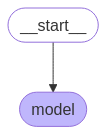

In [197]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [198]:
# The thread id is a unique key that identifies
# this particular conversation.
# We'll just generate a random uuid here.
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}

query = "I'm Bob, how are you?"

system_prompt = "You are a pirate. Answer the following questions as best you can, don't give out unnecessary details"
input_prompt = f"{query}"

input_messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": input_prompt},
]
for event in app.stream({"messages": input_messages}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm Bob, how are you?
================================== Ai Message ==================================

Arr matey, I be fine. And ye be?


In [199]:
query = "Remember my name?"

input_messages = [{"role": "user", "content": query}]
for event in app.stream({"messages": input_messages}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Aye, I remember ye, Bob. What be yer questions?


#### Maintaining memory in langchain

Doc links: 
- Simple chat history https://python.langchain.com/docs/concepts/chat_history/
- Chatbot history https://python.langchain.com/docs/how_to/chatbots_memory/
- With LangGraph and agents https://langchain-ai.github.io/langgraph/concepts/memory

Memory is a cognitive function that allows people to store, retrieve, and use information to understand their present and future.

<b>Short-term memory</b>, or thread-scoped memory, can be recalled at any time from within a single conversational thread with a user. LangGraph manages short-term memory as a part of your agent's state. State is persisted to a database using a checkpointer so the thread can be resumed at any time. Short-term memory updates when the graph is invoked or a step is completed, and the State is read at the start of each step.

For storing long conversations you can try:
- cleaning parts of the conversation
- summarize older parts of the conversation and store the summary

<b>Long-term memory</b> is shared across conversational threads. It can be recalled at any time and in any thread. 

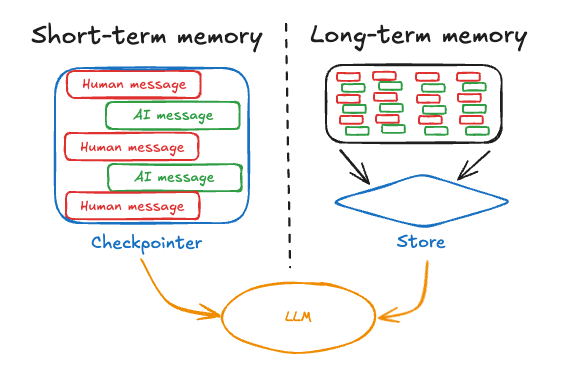

If the flow is simple, you can also manage chat history without langgraph

In [200]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


system = "You are a helpful assistant. Answer all questions to the best of your ability."
query = "Translate from English to French: I love programming."

input_prompt_text = f"{query}"

ai_msg = llm.invoke(
        [   
            SystemMessage(content=system),
            HumanMessage(
                content=input_prompt_text
            ),
            AIMessage(content="J'adore la programmation."),
            HumanMessage(content="What did you just say?"),
        ],
)
print(ai_msg.content)

I said, "J'adore la programmation," which means "I love programming" in French. I'm here to help, so if you have any other questions or need further assistance, feel free to ask!


For more information about memory, see another notebook in this part of the course.

## Langchain: Structured output 

Often you have to make LLM respond in a certain format.  
That can be a json, some Pydantic-like structure or maybe even a specific string structure.  
One way would be to ask the model explicitly or to provide examples. You can use Langchain's output parser to process the output and verify the structure.

[Pydantic](https://docs.pydantic.dev/latest/why/) will be covered in more details later in the course.  
For now you can think of it as a smart library for creation and validation [dataclass](https://docs.python.org/3/library/dataclasses.html)-like schemas.

Here we would use pre built [Pydantic output parser](https://python.langchain.com/api_reference/core/output_parsers/langchain_core.output_parsers.pydantic.PydanticOutputParser.html#langchain_core.output_parsers.pydantic.PydanticOutputParser) from Langchain:

In [201]:
from typing import List

from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate

from typing import Optional
from pydantic import BaseModel, Field

Here we define a Pydantic Model, this is a usual way of defining an dataclass-like (key-value) object.

In [202]:
# Pydantic class
class Joke(BaseModel):
    """Joke to tell user."""

    setup: str = Field(description="The setup of the joke")
    punchline: str = Field(description="The punchline to the joke")
    rating: Optional[int] = Field(
        default=None, description="How funny the joke is, from 1 to 10"
    )

Note the `Field` notation above.  
Here we use `PydanticOutputParser.get_format_instructions()` to generate part of the prompt defining structure of the output. 

In [203]:
# Set up a parser
parser = PydanticOutputParser(pydantic_object=Joke)

query = "Tell me a joke about cats"

input_prompt = """Answer the user query. Output must be in strictly in json format:
{format_instructions}


{query}
"""

# Prompt
prompt = ChatPromptTemplate.from_messages(
    [
        ("human", input_prompt),
    ]
).partial(format_instructions=parser.get_format_instructions())

Let's look at the formatted prompt.

As you can see, it utilizes descriptions of the fields from the Pydantic model.

In [204]:
print(prompt.invoke({"query": query}).to_string())

Human: Answer the user query. Output must be in strictly in json format:
The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"description": "Joke to tell user.", "properties": {"setup": {"description": "The setup of the joke", "title": "Setup", "type": "string"}, "punchline": {"description": "The punchline to the joke", "title": "Punchline", "type": "string"}, "rating": {"anyOf": [{"type": "integer"}, {"type": "null"}], "default": null, "description": "How funny the joke is, from 1 to 10", "title": "Rating"}}, "required": ["setup", "punchline"]}
```


Tell me a joke about cats



Now let's run an llm against this prompt.

In [205]:
chain = prompt | llm | parser

chain.invoke({"query": query})

Joke(setup="Why don't cats play poker in the jungle?", punchline='Too many cheetahs!', rating=7)

In [206]:
chain.invoke({"query": "Tell me a joke about a dog"})

Joke(setup='What do you call a dog magician?', punchline='A labracadabrador.', rating=None)

As you can see, result of invocation is an instance of a `Joke` with fields `setup` and `punchline` accessible.

## Langchain callbacks

For some applications it might be useful to be able to use callbacks, one example is handling and tracking errors during the llm calls, another – track token usage and latency of each llm call.  
They can serve any required function and be run on specific chain execution points.  
In this example we can see a runtime logging callback.

Here you can find more on callbacks:
https://python.langchain.com/docs/how_to/#callbacks


In [207]:
from typing import Any, Dict, List

from langchain_core.callbacks import BaseCallbackHandler
from langchain_core.messages import BaseMessage
from langchain_core.outputs import LLMResult
from langchain_core.prompts import ChatPromptTemplate


class LoggingHandler(BaseCallbackHandler):
    def on_chat_model_start(
        self, serialized: Dict[str, Any], messages: List[List[BaseMessage]], **kwargs
    ) -> None:
        print("Chat model started")

    def on_llm_end(self, response: LLMResult, **kwargs) -> None:
        print(f"Chat model ended, response: {response}")

    def on_chain_start(
        self, serialized: Dict[str, Any], inputs: Dict[str, Any], **kwargs
    ) -> None:
        print(f"Chain {serialized.get('name')} started")

    def on_chain_end(self, outputs: Dict[str, Any], **kwargs) -> None:
        print(f"Chain ended, outputs: {outputs}")


callbacks = [LoggingHandler()]
prompt = ChatPromptTemplate.from_template("What is 1 + {number}?")

chain = prompt | llm

chain.invoke({"number": "2"}, config={"callbacks": callbacks})

Error in LoggingHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Chain ChatPromptTemplate started
Chain ended, outputs: messages=[HumanMessage(content='What is 1 + 2?', additional_kwargs={}, response_metadata={})]
Chat model started
Chat model ended, response: generations=[[ChatGeneration(text='The sum of 1 + 2 is:\n\n3', generation_info={'finish_reason': 'stop', 'logprobs': None}, message=AIMessage(content='The sum of 1 + 2 is:\n\n3', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 11, 'total_tokens': 23, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Mistral', 'system_fingerprint': None, 'id': 'chatcmpl-e7e29e279b0ee7f666763fa3fd00e580', 'finish_reason': 'stop', 'logprobs': None}, id='run-3517a3d7-0665-4c29-b6e7-69172eee4224-0', usage_metadata={'input_tokens': 11, 'output_tokens': 12, 'total_tokens': 23, 'input_token_details': {}, 'output_token_details': {}}))]] llm_output={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 11, 'total_tokens

AIMessage(content='The sum of 1 + 2 is:\n\n3', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 11, 'total_tokens': 23, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Mistral', 'system_fingerprint': None, 'id': 'chatcmpl-e7e29e279b0ee7f666763fa3fd00e580', 'finish_reason': 'stop', 'logprobs': None}, id='run-3517a3d7-0665-4c29-b6e7-69172eee4224-0', usage_metadata={'input_tokens': 11, 'output_tokens': 12, 'total_tokens': 23, 'input_token_details': {}, 'output_token_details': {}})

## Langchain function calling

LLM doesn't have some of knowledge: recent information, data it was not trained on etc.  
Apart from that some actions can be much better executed with means other than LLMs.  
You can add function/tool calling to use LLM capabilities to call such function with proper parameters based on user input and to process the result.

Some models support tool calling that doesn't require such complicated chains.  
You can see how it works here: https://python.langchain.com/docs/how_to/tool_calling/

For others you can take a look at the example below.  
Also see https://python.langchain.com/v0.2/docs/how_to/tools_prompting/


Below we are creating a tool to lookup current weather.

In [208]:
 #be careful, since APIs does not allow to get much responses per hour
import requests
from datetime import datetime


def get_current_weather(location:str):
    """
    Get the current weather in a given location

    Args:
        location: The city and state, e.g. San Francisco, CA

    Returns:
        str: Time of request and current weather
    """
    
    # Get coordinates from OpenStreetMap Nominatim
    url = f"https://nominatim.openstreetmap.org/search?q={location}&format=json&limit=1&addressdetails=1&polygon_geojson=1"
    headers = {'User-Agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        if data:
            result = data[0]
            latitude = result['lat']
            longitude = result['lon']
        else:
            print('Could not get your coordinates')
            return None
    else:
        print(f"Error: {response.status_code}")
        return f"You tried to get online weather, but API call failed. Try again later please"
    
    # Get weather data from Open-Meteo
    api_url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true"
    response = requests.get(api_url)
    if response.status_code == 200:
        weather_data = response.json()
        date_str = weather_data['current_weather']['time']
        input_format = '%Y-%m-%dT%H:%M'
        date_obj = datetime.strptime(date_str, input_format)
        output_format = '%A, %B %d, %Y at %I:%M %p'
        human_date_str = date_obj.strftime(output_format)
        temperature_result = f"Temperature for {human_date_str} is {weather_data['current_weather']['temperature']}°C"
        print(f"Tool call result: {temperature_result}")
        return temperature_result
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return None

# Example usage:
location = "London, UK"
temp = get_current_weather(location)

Tool call result: Temperature for Saturday, April 05, 2025 at 06:00 PM is 14.2°C


Langchain provides various abstractions for tools usage, here we use [StructuredTool](https://python.langchain.com/docs/how_to/custom_tools/#structuredtool) to demonstrate the capability.  
You will see another example in a different Notebook of this Module.

In [209]:
from langchain_core.tools import StructuredTool

current_weather_tool = StructuredTool.from_function(func=get_current_weather)

Now let's [bind the tool](https://python.langchain.com/docs/concepts/tool_calling/#tool-binding) to the model

In [210]:
from langchain_mistralai import ChatMistralAI

tools = [current_weather_tool]

tool_llm = ChatMistralAI(temperature=0.0,
                  model= DEFAULT_MODEL["model"],
                  api_key=DEFAULT_MODEL["api_key"],
                  base_url=DEFAULT_MODEL["api_base"])

tool_llm.bind_tools(tools, tool_choice="current_weather_tool")

RunnableBinding(bound=ChatMistralAI(client=<httpx.Client object at 0x000001A80786DEE0>, async_client=<httpx.AsyncClient object at 0x000001A801D775C0>, mistral_api_key=SecretStr('**********'), endpoint='https://mistral-api.llm.lab.epam.com/v1', model='Mistral', temperature=0.0, model_kwargs={}), kwargs={'tools': [{'type': 'function', 'function': {'name': 'get_current_weather', 'description': 'Get the current weather in a given location\n\nArgs:\n    location: The city and state, e.g. San Francisco, CA\n\nReturns:\n    str: Time of request and current weather', 'parameters': {'properties': {'location': {'type': 'string'}}, 'required': ['location'], 'type': 'object'}}}], 'tool_choice': 'current_weather_tool'}, config={}, config_factories=[])

In [211]:
tools

[StructuredTool(name='get_current_weather', description='Get the current weather in a given location\n\nArgs:\n    location: The city and state, e.g. San Francisco, CA\n\nReturns:\n    str: Time of request and current weather', args_schema=<class 'langchain_core.utils.pydantic.get_current_weather'>, func=<function get_current_weather at 0x000001A8079713A0>)]

Here we use `render_text_description`, note that it renders function docstring along with its name.  
This text will be used in the prompt for the llm call.  

In [212]:
from langchain_core.tools import render_text_description
from langchain_core.output_parsers import JsonOutputParser


rendered_tools = render_text_description(tools)
print(rendered_tools)

get_current_weather(location: str) - Get the current weather in a given location

Args:
    location: The city and state, e.g. San Francisco, CA

Returns:
    str: Time of request and current weather


Let's construct the prompt

In [213]:
query = "What's the weather in London now?"
tool_prompt = f"""You are an assistant that has access to the following set of tools. 
Here are the names and descriptions for each tool:

{rendered_tools}

Given the user input, return the name and input of the tool to use. 
Return your response as a JSON blob with 'name' and 'arguments' keys.

The `arguments` should be a dictionary, with keys corresponding 
to the argument names and the values corresponding to the requested values.

Answer the question: {query}
"""


First part of the chain is model generating tool selection and arguments for the selected tool

In [214]:
chain = llm | JsonOutputParser()
chain.invoke(tool_prompt)

{'name': 'get_current_weather', 'arguments': {'location': 'London'}}

Note that we use [`JsonOutputParser`](https://python.langchain.com/docs/how_to/output_parser_json/) here as we requested our model to give response as a json.  
It handles basic parsing of the text which may include wrapped json.

Now let's create a function which will handle the output above to actually make a call to the tool.

In [215]:
from typing import Any, Dict, Optional, TypedDict

from langchain_core.runnables import RunnableConfig


class ToolCallRequest(TypedDict):
    """A typed dict that shows the inputs into the invoke_tool function."""

    name: str
    arguments: Dict[str, Any]


def invoke_tool(
    tool_call_request: ToolCallRequest, config: Optional[RunnableConfig] = None
):
    """A function that we can use the perform a tool invocation.

    Args:
        tool_call_request: a dict that contains the keys name and arguments.
            The name must match the name of a tool that exists.
            The arguments are the arguments to that tool.
        config: This is configuration information that LangChain uses that contains
            things like callbacks, metadata, etc.See LCEL documentation about RunnableConfig.

    Returns:
        output from the requested tool
    """
    tool_name_to_tool = {tool.name: tool for tool in tools}
    name = tool_call_request["name"]
    requested_tool = tool_name_to_tool[name]
    return requested_tool.invoke(tool_call_request["arguments"], config=config)

Full chain:

In [216]:
chain = llm | JsonOutputParser() | invoke_tool
chain.invoke(tool_prompt)

Tool call result: Temperature for Saturday, April 05, 2025 at 06:00 PM is 14.1°C


'Temperature for Saturday, April 05, 2025 at 06:00 PM is 14.1°C'

We can see that the tool was called and the answer was used.

## Examples and common tasks

Let's observe some of the common tasks that one can solve with LLMs.

In [217]:
def generate_response(prompt: str):
    model = ChatOpenAI(temperature=0.0,
                  model= DEFAULT_MODEL["model"],
                  api_key=DEFAULT_MODEL["api_key"],
                  base_url=DEFAULT_MODEL["api_base"])
    result = model.invoke(prompt)
    return result.content
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001A806A3C1D0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001A807909580>, root_client=<openai.OpenAI object at 0x000001A801CD2DE0>, root_async_client=<openai.AsyncOpenAI object at 0x000001A806A3D280>, model_name='Mistral', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://mistral-api.llm.lab.epam.com/v1')

Let's create a review text and demonstrate a few tasks over it

In [218]:
product_review = """\
Got this panda plush toy for my daughter's birthday, \
who loves it and takes it everywhere. It's soft and \
super cute, and its face has a friendly look. It's \
a bit small for what I paid though. I think there \
might be other options that are bigger for the \
same price. It arrived a day earlier than expected, \
so I got to play with it myself before I gave it \
to her.\
"""

**1. Summarization with focus:**

Summarizing the review with focus on specific aspects relevant to the price.

In [219]:
prompt = f""" 
Generate a short summary of a product review from an e-commerce site \
to give feedback to the pricing department, responsible for determining the price of the product.
Summarize the review below in at most 30 words, and focusing on any aspects that are relevant to the price and perceived value.

Review:\n{product_review}

Summary:
"""

print(generate_response(prompt=prompt))

The customer is satisfied with the quality and appearance of the panda plush toy but feels it is small for the price, suggesting there might be better value options elsewhere.


**2. Information extraction:**

Extract certain aspect of the review

In [220]:
prompt = f"""
Summarize the review below in order to give feedback to delivery department. Limit to 30 words.

Review:\n{product_review}

Feedback to delivery department:\
"""

print(generate_response(prompt=prompt))

The delivery was excellent, arriving a day earlier than expected.


**3. Sentiment analysis:**

Classify review into `positive`, `negative` or `neutral` class.

In [221]:
prompt = f"""\
Classify sentiment of the following product review.
Give your answer as a single word, either "positive", "negative" or "neutral".

Review:{product_review}
Sentiment:
"""

print(generate_response(prompt=prompt))

Positive


**4. Entity Extraction:**

Let's have another review and run tasks for extraction of structured information

In [222]:
lamp_review = """
Needed a nice lamp for my bedroom, and this one had \
additional storage and not too high of a price point. \
Got it fast.  The string to our lamp broke during the \
transit and the company happily sent over a new one. \
Came within a few days as well. It was easy to put \
together.  I had a missing part, so I contacted their \
support and they very quickly got me the missing piece! \
Lumina seems to me to be a great company that cares \
about their customers and products!!
"""

prompt = f"""
Identify the following entities from the text:

Company name
Date of contract
Sum of contract
Currency of a contract

The review is delimited with triple backticks. 
Format your response as a JSON object with entities the keys and recognized entities as values. 
If the information isn't present, use "unknown" as the value. Make your response as short as possible.

Text: ```{lamp_review}```
"""

print(generate_response(prompt=prompt))

```json
{
  "Company name": "Lumina",
  "Date of contract": "unknown",
  "Sum of contract": "unknown",
  "Currency of a contract": "unknown"
}
```


**5. Topic recognition (open topics):**

Here we will ask the model to generate an open list of topics for the text.

In [223]:
story = """
In a recent survey conducted by the government, 
public sector employees were asked to rate their level 
of satisfaction with the department they work at. 
The results revealed that NASA was the most popular 
department with a satisfaction rating of 95%.

One NASA employee, John Smith, commented on the findings, 
stating, "I'm not surprised that NASA came out on top. 
It's a great place to work with amazing people and 
incredible opportunities. I'm proud to be a part of 
such an innovative organization."

The results were also welcomed by NASA's management team, 
with Director Tom Johnson stating, "We are thrilled to 
hear that our employees are satisfied with their work at NASA. 
We have a talented and dedicated team who work tirelessly 
to achieve our goals, and it's fantastic to see that their 
hard work is paying off."

The survey also revealed that the 
Social Security Administration had the lowest satisfaction 
rating, with only 45% of employees indicating they were 
satisfied with their job. The government has pledged to 
address the concerns raised by employees in the survey and 
work towards improving job satisfaction across all departments.
"""

In [224]:
prompt = f""" 
Determine five topics that are being discussed in the provided text.
Make each item one or two words long.
Give topics in Python list format.

Text sample: '''{story}'''
"""

print(generate_response(prompt=prompt))

```python
topics = [
    "Survey",
    "NASA",
    "Employee Satisfaction",
    "Social Security",
    "Government"
]
```


**6. Topic recognition (closed list of topics):**

Here we are asking the model to assign topics from the closed list to the text.

In [225]:
topic_list = ["NASA", "Security", "Biology"]

prompt = f"""

Recognize a topic from the given topic list delimited in triple backticks 
that is being discussed in the text, which is delimited by triple quotes. If you cannot determine between these 3, return 'other'.

Topic list: ```{topic_list}```

Text sample: '''{story}'''

Provide an answer only with one word, representing a determined topic.
"""

print(generate_response(prompt=prompt))

NASA


**7. Translation:**

In [226]:
text = """Translate provided text to Spanish:

Hello! How are you?"""

print(generate_response(prompt=text))

Sure, here is the translation of "Hello! How are you?" to Spanish:

"¡Hola! ¿Cómo estás?"

If you want a more formal version, you can use:

"¡Hola! ¿Cómo está?"


**8. Tone transforming:**

In [227]:
text = "Hi, man! Nice to see you. I will not be ready with my task, is it ok?"
prompt = f""" Translate the following from slang to a business letter: {text}. """

print(generate_response(prompt=prompt))

Here's how you can translate the given slang into a formal business letter:

---

Dear [Recipient's Name],

I hope this message finds you well.

I am writing to inform you that I will not be able to complete my task by the previously agreed deadline. I apologize for any inconvenience this may cause.

Could you please confirm if this delay is acceptable?

Thank you for your understanding.

Best regards,

[Your Name]

---


**9. Spellcheck / Grammar check:**

In [228]:
text = """Proofread and correct user message. Explain made corrections.

User message:
Hi, man! Nise to see you. I wont not be raedy with my task, it is ok?"""


print(generate_response(prompt=text))

Here is the corrected version of the user message:

"Hi, man! Nice to see you. I won't be ready with my task, is it okay?"

### Corrections Made:
1. **"Nise"** to **"Nice"**: Corrected the spelling error.
2. **"I wont not be raedy"** to **"I won't be ready"**: Corrected the double negative and spelling error.
3. **"it is ok?"** to **"is it okay?"**: Changed the sentence structure for better clarity and added a question mark for proper punctuation.

The corrected message is more grammatically accurate and clearer.


**10. Multiple tasks at the same time:**  

Be aware that a prompt with multiple tasks tends to be less stable and correct than several prompts each for its own task.

In [229]:
lamp_review = """
Needed a nice lamp for my bedroom, and this one had \
additional storage and not too high of a price point. \
Got it fast.  The string to our lamp broke during the \
transit and the company happily sent over a new one. \
Came within a few days as well. It was easy to put \
together.  I had a missing part, so I contacted their \
support and they very quickly got me the missing piece! \
Lumina seems to me to be a great company that cares \
about their customers and products!!
"""

prompt = f""" Identify the following items from the review text:

Sentiment (positive or negative)
Is the reviewer expressing anger? (true or false)
Item purchased by reviewer
Company that made the item

The review is delimited with triple backticks. 
Format your response as a JSON object with "Sentiment", "Anger", "Item" and "Brand" as the keys. 
If the information isn't present, use "unknown"as the value. 
Make your response as short as possible. Format the Anger value as a boolean.

Review text: '''{lamp_review}''' 
"""
print(generate_response(prompt=prompt))

```json
{
  "Sentiment": "positive",
  "Anger": false,
  "Item": "lamp",
  "Brand": "Lumina"
}
```


## Task

Now it is time for you to utilize the examples above to complete a task.

Given project description, generate a possible team for it's implementation.  
Result should be a Pydantic model.

Input example:
Project description: A video-hosting service with ~100k users written on Python.

Output example:
>Team(members=[Member(role="Developer", seniority="Middle", description="Python developer with Django experience"], Member(role="QA", seniority="Junior", description="Manual QA Engineer with some experience of testing web applications"), .... etc])

The structure is approximate

In [230]:
import os
from typing import List
from dotenv import load_dotenv
from pydantic import BaseModel

from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.chains import LLMChain

# Load .env variables (like OPENAI_API_KEY)
load_dotenv()

# Pydantic schema for structured output
class Member(BaseModel):
    role: str
    seniority: str
    description: str

class Team(BaseModel):
    members: List[Member]

# Setup parser
parser = PydanticOutputParser(pydantic_object=Team)

# Create prompt with format instructions
prompt = ChatPromptTemplate.from_template("""
You are a helpful assistant that generates a valid JSON team description.

Given the following project description:
"{query}"

Generate a team composition for implementing the project.

{format_instructions}
""")

# LLM setup
llm = ChatOpenAI(temperature=0)

# Chain setup
chain = LLMChain(
    llm=llm,
    prompt=prompt.partial(format_instructions=parser.get_format_instructions()),
    output_parser=parser
)

# Fix: extract model from 'text' key of result dict
def generate_team_for_project(description: str) -> Team:
    result = chain.invoke({"query": description})
    return result["text"]  # this is already a Team instance due to output_parser

# Example usage
if __name__ == "__main__":
    project_description = "A video-hosting service with ~100k users written in Python."
    team = generate_team_for_project(project_description)

    print("✅ Team composition:")
    for i, member in enumerate(team.members, 1):
        print(f"{i}. {member.role} ({member.seniority}) – {member.description}")


✅ Team composition:
1. Backend Developer (Senior) – Responsible for developing the backend logic of the video-hosting service in Python.
2. Frontend Developer (Senior) – Responsible for designing and implementing the user interface of the video-hosting service.
3. DevOps Engineer (Senior) – Responsible for managing the deployment and infrastructure of the video-hosting service.
4. QA Engineer (Mid) – Responsible for testing and ensuring the quality of the video-hosting service.


In [231]:
from typing import List

from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate

from typing import Optional
from pydantic import BaseModel, Field

In [232]:
result = chain.invoke({"query": query})

In [233]:
assert isinstance(result["text"], Team)

Assertion passed, json is validated, created team makes sense.